In [7]:
# ----------------------------------------------
# Yolo Keras Hand Detection
# ----------------------------------------------

from datetime import datetime
import numpy as np
import sys, getopt
import cv2
import os
from keras import backend as K
import time

os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras.models import load_model
from keras.preprocessing import image

from matplotlib import pyplot as plt

#YOLOV2
#reference from https://github.com/experiencor/keras-yolo2
# https://github.com/experiencor/keras-yolo2/blob/master/LICENSE


In [2]:
def interpret_output_yolov2(output, img_width, img_height):
	anchors=[0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]

	netout=output
	nb_class=1
	obj_threshold=0.4
	nms_threshold=0.3

	grid_h, grid_w, nb_box = netout.shape[:3]

	size = 4 + nb_class + 1;
	nb_box=5

	netout=netout.reshape(grid_h,grid_w,nb_box,size)

	boxes = []
	
	# decode the output by the network
	netout[..., 4]  = _sigmoid(netout[..., 4])
	netout[..., 5:] = netout[..., 4][..., np.newaxis] * _softmax(netout[..., 5:])
	netout[..., 5:] *= netout[..., 5:] > obj_threshold

	for row in range(grid_h):
		for col in range(grid_w):
			for b in range(nb_box):
				# from 4th element onwards are confidence and class classes
				classes = netout[row,col,b,5:]
				
				if np.sum(classes) > 0:
					# first 4 elements are x, y, w, and h
					x, y, w, h = netout[row,col,b,:4]

					x = (col + _sigmoid(x)) / grid_w # center position, unit: image width
					y = (row + _sigmoid(y)) / grid_h # center position, unit: image height
					w = anchors[2 * b + 0] * np.exp(w) / grid_w # unit: image width
					h = anchors[2 * b + 1] * np.exp(h) / grid_h # unit: image height
					confidence = netout[row,col,b,4]
					
					box = bounding_box(x-w/2, y-h/2, x+w/2, y+h/2, confidence, classes)
					
					boxes.append(box)

	# suppress non-maximal boxes
	for c in range(nb_class):
		sorted_indices = list(reversed(np.argsort([box.classes[c] for box in boxes])))

		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			
			if boxes[index_i].classes[c] == 0: 
				continue
			else:
				for j in range(i+1, len(sorted_indices)):
					index_j = sorted_indices[j]
					
					if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_threshold:
						boxes[index_j].classes[c] = 0
						
	# remove the boxes which are less likely than a obj_threshold
	boxes = [box for box in boxes if box.get_score() > obj_threshold]
	
	result = []
	for i in range(len(boxes)):
		if(boxes[i].classes[0]==0):
			continue
		predicted_class = "hand"
		score = boxes[i].score
		result.append([predicted_class,(boxes[i].xmax+boxes[i].xmin)*img_width/2,(boxes[i].ymax+boxes[i].ymin)*img_height/2,(boxes[i].xmax-boxes[i].xmin)*img_width,(boxes[i].ymax-boxes[i].ymin)*img_height,score])

	return result

class bounding_box:
	def __init__(self, xmin, ymin, xmax, ymax, c = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		
		self.c     = c
		self.classes = classes

		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
		
		return self.label
	
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
			
		return self.score

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])  
	
	intersect = intersect_w * intersect_h

	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	
	union = w1*h1 + w2*h2 - intersect
	
	return float(intersect) / union

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b

	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3          

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def _softmax(x, axis=-1, t=-100.):
	x = x - np.max(x)
	
	if np.min(x) < t:
		x = x/np.min(x)*t
		
	e_x = np.exp(x)
	
	return e_x / e_x.sum(axis, keepdims=True)

#crop
def crop(x,y,w,h,margin,img_width,img_height):
	xmin = int(x-w*margin)
	xmax = int(x+w*margin)
	ymin = int(y-h*margin)
	ymax = int(y+h*margin)
	if xmin<0:
		xmin = 0
	if ymin<0:
		ymin = 0
	if xmax>img_width:
		xmax = img_width
	if ymax>img_height:
		ymax = img_height
	return xmin,xmax,ymin,ymax

#display result
def show_results(img,results, img_width, img_height):
	img_cp = img.copy()
	print('len results:',len(results))
	img_cp1 = cv2.cvtColor(img_cp, cv2.COLOR_BGR2RGB)
	for i in range(len(results)):
		x = int(results[i][1])
		y = int(results[i][2])
		w = int(results[i][3])//2
		h = int(results[i][4])//2

		xmin,xmax,ymin,ymax=crop(x,y,w,h,1.0,img_width,img_height)

		cv2.rectangle(img_cp1,(xmin,ymin),(xmax,ymax),(0,255,0), 30)
		cv2.rectangle(img_cp1,(xmin,ymin-20),(xmax,ymin),(125,125,125),-1)
		cv2.putText(img_cp1,results[i][0] + ' : %.2f' % results[i][5],(xmin+5,ymin-7),cv2.FONT_HERSHEY_SIMPLEX,2,(255,0, 0), 12 , cv2.LINE_AA)
	return img_cp1 #cv2.imshow('YoloKerasHandDetection',img_cp)


In [3]:
MODEL_ROOT_PATH="./pretrain/"

#Load Model
model_hand = load_model(MODEL_ROOT_PATH+'yolov2_tiny-hand.h5')

/root/team3/yes/envs/YoloKeras/lib/python3.6/site-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


1591376938.3267334
prediction time: 0.46171069145202637
len results: 2


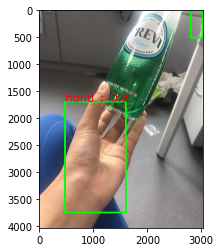

In [5]:

img=cv2.imread('./hand/5.jpg', cv2.IMREAD_COLOR)
img = img[...,::-1]  #BGR 2 RGB
inputs = img.copy() / 255.0

img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_camera = cv2.resize(inputs, (416,416))
img_camera = np.expand_dims(img_camera, axis=0)
start = time.time()
print(start)
out2 = model_hand.predict(img_camera)[0]
end = time.time()
print('prediction time:',end-start)
results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])

#Age and Gender Detection
img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
plt.imshow(img_cp)
plt.imsave('save.png',img_cp)


In [6]:
from os import listdir
from os.path import isfile, join

target_dir = './hand'
files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

['8.jpg', '3.jpg', '5.jpg', '2.jpg', '1.jpg', 'wild_hand.jpg', '9.jpg', '4.jpg', '6.jpg', '7.jpg', 'wallet.jpg', 'wallet2.jpg']


In [4]:
def get_result(img_path,img_name, dst_dir):

  file_name = os.path.join(dst_dir,img_name[:-4]+'_result.png')
  img=cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = img[...,::-1]  #BGR 2 RGB
  inputs = img.copy() / 255.0
  
  img_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img_camera = cv2.resize(inputs, (416,416))
  img_camera = np.expand_dims(img_camera, axis=0)
  start = time.time()
  out2 = model_hand.predict(img_camera)[0]
  end = time.time()
  print('prediction time:',end-start)
  start = time.time()
  results = interpret_output_yolov2(out2, img.shape[1], img.shape[0])
  end = time.time()
  print('interpret time:',end-start)

  #Age and Gender Detection
  img_cp=show_results(img_cv,results, img.shape[1], img.shape[0])
  plt.imshow(img_cp)
  print(file_name)
  plt.imsave(file_name,img_cp)

prediction time: 0.22957897186279297
interpret time: 0.012116432189941406
len results: 2
./result/5_result.png


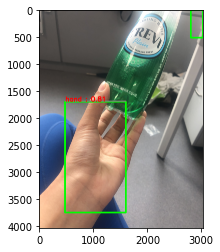

In [14]:
get_result('./hand/5.jpg','5.jpg','./result')

['B1_PS_H_test_000089.jpg', 'B1_PS_H_test_000004.jpg', 'B1_PS_H_test_000087.jpg', 'B1_PS_H_test_000064.jpg', 'B1_PS_H_test_000050.jpg', 'B1_PS_H_test_000020.jpg', 'B1_PS_H_test_000094.jpg', 'B1_PS_H_test_000015.jpg', 'B1_PS_H_test_000012.jpg', 'B1_PS_H_test_000069.jpg', 'B1_PS_H_test_000053.jpg', 'B1_PS_H_test_000040.jpg', 'B1_PS_H_test_000013.jpg', 'B1_PS_H_test_000083.jpg', 'B1_PS_H_test_000084.jpg', 'B1_PS_H_test_000085.jpg', 'B1_PS_H_test_000045.jpg', 'B1_PS_H_test_000018.jpg', 'B1_PS_H_test_000076.jpg', 'B1_PS_H_test_000049.jpg', 'B1_PS_H_test_000081.jpg', 'B1_PS_H_test_000057.jpg', 'B1_PS_H_test_000034.jpg', 'B1_PS_H_test_000088.jpg', 'B1_PS_H_test_000046.jpg', 'B1_PS_H_test_000043.jpg', 'B1_PS_H_test_000019.jpg', 'B1_PS_H_test_000029.jpg', 'B1_PS_H_test_000021.jpg', 'B1_PS_H_test_000070.jpg', 'B1_PS_H_test_000060.jpg', 'B1_PS_H_test_000065.jpg', 'B1_PS_H_test_000024.jpg', 'B1_PS_H_test_000059.jpg', 'B1_PS_H_test_000062.jpg', 'B1_PS_H_test_000009.jpg', 'B1_PS_H_test_000032.jpg', 

prediction time: 0.09085965156555176
interpret time: 0.007199764251708984
len results: 3
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000029_result.png
prediction time: 0.09356021881103516
interpret time: 0.007155418395996094
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000021_result.png
prediction time: 0.08897137641906738
interpret time: 0.006978511810302734
len results: 2
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000070_result.png
prediction time: 0.1013329029083252
interpret time: 0.006949663162231445
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000060_result.png
prediction time: 0.0910191535949707
interpret time: 0.006945133209228516
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B

prediction time: 0.09148788452148438
interpret time: 0.006777286529541016
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000010_result.png
prediction time: 0.09085941314697266
interpret time: 0.006476879119873047
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000023_result.png
prediction time: 0.10851263999938965
interpret time: 0.0068323612213134766
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000082_result.png
prediction time: 0.08999276161193848
interpret time: 0.006585597991943359
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/B1_PS_H_test_000035_result.png
prediction time: 0.10298275947570801
interpret time: 0.0064127445220947266
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-wi

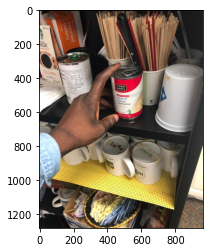

In [18]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
target_dir = './TEgO/Testing/Images/in-the-wild/B1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/'

dst_dir = os.path.join(PWD ,dst_dir_sangdae)

if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

In [ ]:
# img_path,img_name, dst_dir
PWD = os.getcwd()
target_dir = './TEgO/Testing/Images/in-the-wild/B1_PS_H_test/'
dst_dir_sangdae = 'TEgO_result/Testing/Images/in-the-wild/B1_PS_H_test/'

dst_dir = os.path.join(PWD ,dst_dir_sangdae)

if not os.path.isdir(dst_dir):
    os.makedirs(dst_dir)

files = [f for f in listdir(target_dir) if isfile(join(target_dir, f))]
print(files)

for i in files:
   file_name = os.path.join(target_dir,i)
   get_result(file_name, i,dst_dir )

In [23]:
import os

def experiment(target_subdir,dst_dir):
    
    if not os.path.isdir(dst_dir):
        os.makedirs(dst_dir)

    files = [f for f in os.listdir(target_subdir) if os.path.isfile(os.path.join(target_subdir, f))]
    print(files)

    for i in files:
       file_name = os.path.join(target_subdir,i)
       get_result(file_name, i,dst_dir )


In [9]:
PWD = os.getcwd()
target_str = 'TEgO/Testing/Images/in-the-vanilla/'
dst_dir_str = 'TEgO_result/Testing/Images/in-the-vanilla/'
target_dir = os.path.join(PWD ,target_str)
dst_dir_str = os.path.join(PWD ,dst_dir_str)
a = os.listdir(target_dir)

In [10]:
print(a)

['B1_PS_NH_test', 'S1_PS_H_test_NIL', 'B1_PV_H_test_torch', 'S1_PS_H_test_torch', 'S1_PS_NH_test', 'S1_PS_H_test', 'B1_PV_NH_test_torch', 'B1_PV_H_test', 'B1_PV_H_test_NIL', 'B1_PS_H_test_torch', 'B1_PV_NH_test', 'S1_PS_NH_test_torch', 'B1_PV_NH_test_NIL', 'B1_PS_H_test_NIL', 'B1_PS_H_test', 'B1_PS_NH_test_torch', 'B1_PS_NH_test_NIL', 'S1_PS_NH_test_NIL']


In [11]:
print(target_dir)
print(dst_dir_str)
target_subdirs = [os.path.join(target_dir, direc) for direc in a]
dst_subdirs = [os.path.join(dst_dir_str, direc) for direc in a]


/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/


In [12]:
print(target_subdirs)

['/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/S1_PS_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO/Testing/Images/in-the-vanilla/B1_PV_NH_te

In [13]:
print(dst_subdirs)

['/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_NIL', '/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_H_test_torch', '/root/Edwin/h

In [ ]:
for i in range(len(target_subdirs)):
    experiment(target_subdirs[i],dst_subdirs[i])

['B1_PS_NH_test_000086.jpg', 'B1_PS_NH_test_000071.jpg', 'B1_PS_NH_test_000000.jpg', 'B1_PS_NH_test_000015.jpg', 'B1_PS_NH_test_000025.jpg', 'B1_PS_NH_test_000011.jpg', 'B1_PS_NH_test_000079.jpg', 'B1_PS_NH_test_000026.jpg', 'B1_PS_NH_test_000030.jpg', 'B1_PS_NH_test_000045.jpg', 'B1_PS_NH_test_000008.jpg', 'B1_PS_NH_test_000094.jpg', 'B1_PS_NH_test_000043.jpg', 'B1_PS_NH_test_000004.jpg', 'B1_PS_NH_test_000074.jpg', 'B1_PS_NH_test_000010.jpg', 'B1_PS_NH_test_000083.jpg', 'B1_PS_NH_test_000034.jpg', 'B1_PS_NH_test_000028.jpg', 'B1_PS_NH_test_000084.jpg', 'B1_PS_NH_test_000037.jpg', 'B1_PS_NH_test_000007.jpg', 'B1_PS_NH_test_000080.jpg', 'B1_PS_NH_test_000009.jpg', 'B1_PS_NH_test_000052.jpg', 'B1_PS_NH_test_000031.jpg', 'B1_PS_NH_test_000082.jpg', 'B1_PS_NH_test_000038.jpg', 'B1_PS_NH_test_000061.jpg', 'B1_PS_NH_test_000042.jpg', 'B1_PS_NH_test_000067.jpg', 'B1_PS_NH_test_000064.jpg', 'B1_PS_NH_test_000051.jpg', 'B1_PS_NH_test_000022.jpg', 'B1_PS_NH_test_000077.jpg', 'B1_PS_NH_test_0000

prediction time: 0.09049177169799805
interpret time: 0.007091522216796875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000082_result.png
prediction time: 0.09843015670776367
interpret time: 0.007052421569824219
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000038_result.png
prediction time: 0.08881759643554688
interpret time: 0.007149696350097656
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000061_result.png
prediction time: 0.09093642234802246
interpret time: 0.007022857666015625
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000042_result.png
prediction time: 0.0908207893371582
interpret time: 0.0066776275634765625
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testin

prediction time: 0.09503841400146484
interpret time: 0.006573677062988281
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000019_result.png
prediction time: 0.09279346466064453
interpret time: 0.0065691471099853516
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000020_result.png
prediction time: 0.0905613899230957
interpret time: 0.006573200225830078
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000091_result.png
prediction time: 0.10434627532958984
interpret time: 0.006720781326293945
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PS_NH_test/B1_PS_NH_test_000085_result.png
prediction time: 0.09335803985595703
interpret time: 0.00655674934387207
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing

prediction time: 0.09257268905639648
interpret time: 0.006662845611572266
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000081_result.png
prediction time: 0.0916898250579834
interpret time: 0.0066492557525634766
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000077_result.png
prediction time: 0.09370732307434082
interpret time: 0.007109165191650391
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000058_result.png
prediction time: 0.08863186836242676
interpret time: 0.007506847381591797
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000060_result.png
prediction time: 0.09214568138122559
interpret time: 0.006513833999633789
len results: 0
/root/Edwin/hand-detection-Yolo

prediction time: 0.0928032398223877
interpret time: 0.006989002227783203
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000078_result.png
prediction time: 0.09291648864746094
interpret time: 0.006973981857299805
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000019_result.png
prediction time: 0.09668397903442383
interpret time: 0.006523609161376953
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000069_result.png
prediction time: 0.09705829620361328
interpret time: 0.007031917572021484
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000037_result.png
prediction time: 0.09105420112609863
interpret time: 0.007050275802612305
len results: 0
/root/Edwin/hand-detection-YoloK

prediction time: 0.08923029899597168
interpret time: 0.007153749465942383
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000026_result.png
prediction time: 0.09149599075317383
interpret time: 0.0065577030181884766
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000065_result.png
prediction time: 0.09438753128051758
interpret time: 0.0071125030517578125
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000011_result.png
prediction time: 0.08896780014038086
interpret time: 0.00684046745300293
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_NIL/S1_PS_H_test_NIL_000082_result.png
prediction time: 0.09601688385009766
interpret time: 0.00682377815246582
len results: 0
/root/Edwin/hand-detection-Yolo

prediction time: 0.09345674514770508
interpret time: 0.007012128829956055
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000076_result.png
prediction time: 0.09424138069152832
interpret time: 0.006930351257324219
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000084_result.png
prediction time: 0.0967261791229248
interpret time: 0.006923198699951172
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000089_result.png
prediction time: 0.0944056510925293
interpret time: 0.006737709045410156
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000004_result.png
prediction time: 0.09375834465026855
interpret time: 0.007098197937011719
len results: 0
/root/Edwin/hand-

prediction time: 0.09774470329284668
interpret time: 0.006953239440917969
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000072_result.png
prediction time: 0.09508419036865234
interpret time: 0.007014751434326172
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000040_result.png
prediction time: 0.0904695987701416
interpret time: 0.006762981414794922
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000032_result.png
prediction time: 0.09884881973266602
interpret time: 0.006731271743774414
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000002_result.png
prediction time: 0.09211921691894531
interpret time: 0.007046699523925781
len results: 0
/root/Edwin/hand

prediction time: 0.09205937385559082
interpret time: 0.007028341293334961
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000016_result.png
prediction time: 0.09986376762390137
interpret time: 0.007224082946777344
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000059_result.png
prediction time: 0.09323787689208984
interpret time: 0.007083892822265625
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000091_result.png
prediction time: 0.09921407699584961
interpret time: 0.006993770599365234
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_H_test_torch/B1_PV_H_test_torch_000008_result.png
prediction time: 0.0914926528930664
interpret time: 0.007020235061645508
len results: 0
/root/Edwin/hand

prediction time: 0.09570121765136719
interpret time: 0.006758689880371094
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000076_result.png
prediction time: 0.0950016975402832
interpret time: 0.007077693939208984
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000045_result.png
prediction time: 0.0927438735961914
interpret time: 0.006543874740600586
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000093_result.png
prediction time: 0.09386825561523438
interpret time: 0.0065898895263671875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000072_result.png
prediction time: 0.09412217140197754
interpret time: 0.006910800933837891
len results: 0
/root/Edwin/hand

prediction time: 0.0952455997467041
interpret time: 0.010373115539550781
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000049_result.png
prediction time: 0.09250497817993164
interpret time: 0.00701594352722168
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000053_result.png
prediction time: 0.09507107734680176
interpret time: 0.0067729949951171875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000012_result.png
prediction time: 0.10135102272033691
interpret time: 0.007048845291137695
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000086_result.png
prediction time: 0.08971309661865234
interpret time: 0.006571292877197266
len results: 0
/root/Edwin/hand

prediction time: 0.09073305130004883
interpret time: 0.0070650577545166016
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000028_result.png
prediction time: 0.09551811218261719
interpret time: 0.007042407989501953
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000023_result.png
prediction time: 0.0949254035949707
interpret time: 0.006678342819213867
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000009_result.png
prediction time: 0.09887862205505371
interpret time: 0.007057666778564453
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test_torch/S1_PS_H_test_torch_000026_result.png
prediction time: 0.09676623344421387
interpret time: 0.007073879241943359
len results: 0
/root/Edwin/han

prediction time: 0.09327888488769531
interpret time: 0.0069026947021484375
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000048_result.png
prediction time: 0.09747004508972168
interpret time: 0.006506443023681641
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000082_result.png
prediction time: 0.10088253021240234
interpret time: 0.0071392059326171875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000021_result.png
prediction time: 0.09214305877685547
interpret time: 0.006509542465209961
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000088_result.png
prediction time: 0.09337973594665527
interpret time: 0.006953239440917969
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Test

prediction time: 0.09510636329650879
interpret time: 0.006978750228881836
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000045_result.png
prediction time: 0.09823417663574219
interpret time: 0.00700068473815918
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000038_result.png
prediction time: 0.09161067008972168
interpret time: 0.006472349166870117
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000061_result.png
prediction time: 0.10205411911010742
interpret time: 0.006728172302246094
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000092_result.png
prediction time: 0.0952146053314209
interpret time: 0.006600856781005859
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/

prediction time: 0.09068918228149414
interpret time: 0.0070629119873046875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000069_result.png
prediction time: 0.10297608375549316
interpret time: 0.00711822509765625
len results: 1
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000090_result.png
prediction time: 0.08919310569763184
interpret time: 0.007079601287841797
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000051_result.png
prediction time: 0.10061311721801758
interpret time: 0.006967306137084961
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_NH_test/S1_PS_NH_test_000007_result.png
prediction time: 0.09138274192810059
interpret time: 0.007155418395996094
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testin

prediction time: 0.10754513740539551
interpret time: 0.006902456283569336
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000009_result.png
prediction time: 0.09701299667358398
interpret time: 0.007066011428833008
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000052_result.png
prediction time: 0.09658241271972656
interpret time: 0.007199764251708984
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000063_result.png
prediction time: 0.09232711791992188
interpret time: 0.006727457046508789
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000031_result.png
prediction time: 0.10314702987670898
interpret time: 0.007127523422241211
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images

prediction time: 0.09189271926879883
interpret time: 0.007118701934814453
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000056_result.png
prediction time: 0.10128569602966309
interpret time: 0.007036447525024414
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000032_result.png
prediction time: 0.09145903587341309
interpret time: 0.007058382034301758
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000059_result.png
prediction time: 0.09732961654663086
interpret time: 0.00699615478515625
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/S1_PS_H_test/S1_PS_H_test_000093_result.png
prediction time: 0.09138274192810059
interpret time: 0.006603240966796875
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/

prediction time: 0.09656572341918945
interpret time: 0.006980419158935547
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch/B1_PV_NH_test_torch_000049_result.png
prediction time: 0.09187936782836914
interpret time: 0.006779193878173828
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch/B1_PV_NH_test_torch_000027_result.png
prediction time: 0.09912419319152832
interpret time: 0.007133007049560547
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch/B1_PV_NH_test_torch_000052_result.png
prediction time: 0.09244513511657715
interpret time: 0.006788969039916992
len results: 0
/root/Edwin/hand-detection-YoloKeras/TEgO_result/Testing/Images/in-the-vanilla/B1_PV_NH_test_torch/B1_PV_NH_test_torch_000079_result.png
prediction time: 0.11565375328063965
interpret time: 0.007095813751220703
len results: 0
/root/E